In [1]:
import os, sys
cur_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(cur_dir, os.pardir, os.pardir))
save_dir = os.path.join(cur_dir, 'saved')
sys.path.append(project_dir)

In [2]:
import numpy as np
import numpy.random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import torch as tc
import tensorflow as tf
import argparse
import pickle
import pandas as pd
from circuit_solver import circuit as ct
from circuit_solver import elements as es
from circuit_solver import utils
from circuit_solver.learning import CoupledLearning, CLTrainingConfig, CLTestingConfig

# Set run parameters

In [3]:
def run_params():
    description = 'crossbar performance'

    # data params
    downsample_size = (7,7)
    input_gain = 20.0
    output_gain = 1.0
    
    # # element params
    element = es.Resistor()
    k_min = 1E-1
    k_max = 1E1
    element.param_ranges = [(k_min, k_max)]
    element.init_mode = 'constant'
    element.init_params = k_min
    
    # training_config
    batch_size = 50
    eta = 1
    alpha = 0.01
    N_batch = 1000

    return argparse.Namespace(**locals())

v = run_params()
dataframe_keys = set(vars(v).keys())
dataframe_keys.add('timestamp')

v.training_config = CLTrainingConfig(
    batch_size=v.batch_size,
    N_batches=v.N_batch,
    eta=v.eta,
    alpha=v.alpha
)

absolute_high = max(v.input_gain, v.output_gain) 
v.model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
)

# df = utils.refresh_index(save_dir, dataframe_keys=dataframe_keys)

In [4]:
# columns = ['timestamp', 'element', 'eta', 'alpha', 'N_epochs', ]
columns = dataframe_keys
df = utils.view_index(save_dir, columns)
# df

No index found at /Users/adamkline/Projects/circuit-solver/circuit_solver/examples/saved/index.csv


# Load and process data

In [5]:
# Training examples from the dataset. Initial shapes: x_train (P, 28, 28), y_train (P,)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Turn data into format that can be passed into circuit model
X_train, Y_train = utils.preprocess_MNIST_data(x_train, y_train, size=v.downsample_size, X_gain=v.input_gain, Y_gain=v.output_gain)
X_test, Y_test = utils.preprocess_MNIST_data(x_test, y_test, size=v.downsample_size, X_gain=v.input_gain, Y_gain=v.output_gain)

P_train, N = X_train.shape
P_test, M = Y_test.shape

# Build circuit model

In [6]:
N_nodes = N + M
graph = nx.DiGraph()
graph.add_nodes_from(range(N_nodes))

# define indices for different node types
GROUND, HIGH, LOW, x_nodes, y_nodes = utils.segment_array(graph.nodes, (None, None, None, N, M))   # HIGH = [], LOW = []

fixed_nodes = GROUND + HIGH + LOW + x_nodes

# bipartite graph
all_edges = utils.all_pairs_between(fixed_nodes, y_nodes)
graph.add_edges_from(all_edges)

# initialize Circuit
element_dict = {
    v.element: all_edges,
}

v.circuit = ct.Circuit(graph, element_dict)
# plt.subplots(dpi=300)
# plt.imshow(v.circuit.Del.toarray().T)

In [7]:
v.node_type_dict = {
    'GROUND': GROUND,
    'HIGH': HIGH,
    'LOW': LOW,
    'x': x_nodes,
    'y': y_nodes,
}

model = ct.CircuitModel(v.circuit, v.node_type_dict, v.model_config)

# Run training

In [8]:
v.history = CoupledLearning(X_train, Y_train, model, v.training_config)
v.accuracy_mean = np.mean(v.history['accuracy'][:-100])
v.loss_mean = np.mean(v.history['loss'][:-100])
v.accuracy_var = np.var(v.history['accuracy'][:-100])
v.loss_var = np.var(v.history['loss'][:-100])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:17<00:00, 58.20it/s]


In [9]:
theta = v.history[v.element.name]
N_params = theta.shape[0] 

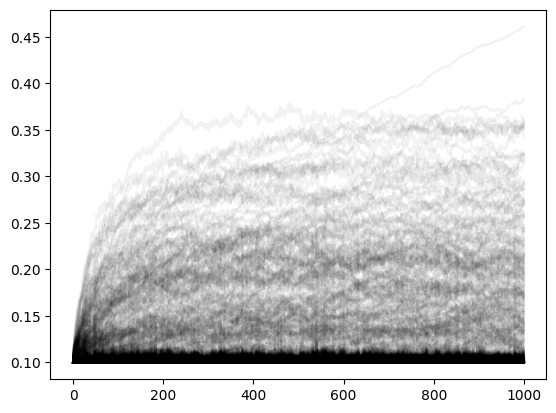

In [10]:
if N_params > 1:
    fig, ax = plt.subplots(ncols=N_params, figsize=[5*N_params,5])
    for n in range(N_params):
        ax[n].plot(theta[n], color='k', alpha=0.05);
else:
    plt.plot(theta[0], color='k', alpha=0.05)

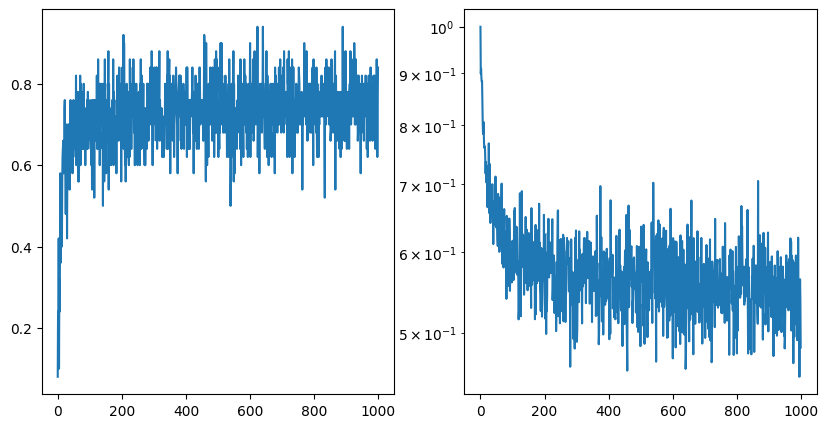

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=[10,5])
ax[0].plot(v.history['accuracy'])
ax[1].semilogy(v.history['loss'])

# Save data

In [12]:
from time import gmtime, strftime, localtime

# save things
v.timestamp = strftime("%y%m/%d %Hh%Mm%Ss",localtime())
v.full_file_path = os.path.join(save_dir, f'{v.timestamp}.dat')
dataframe_keys.add('timestamp')

print("WILL SAVE FOLLOWING VARIABLES\n")
for key in vars(v).keys():
    going_to_dataframe = '   (*)  ' if key in dataframe_keys else '\t'
    print(going_to_dataframe + key)

print(f"\nTO THE PATH\n")
print('\t...' + '/'.join(v.full_file_path.split('/')[-4:]))

WILL SAVE FOLLOWING VARIABLES

   (*)  description
   (*)  downsample_size
   (*)  input_gain
   (*)  output_gain
   (*)  element
   (*)  k_min
   (*)  k_max
   (*)  batch_size
   (*)  eta
   (*)  alpha
   (*)  N_batch
	training_config
	model_config
	circuit
	node_type_dict
	history
	accuracy_mean
	loss_mean
	accuracy_var
	loss_var
   (*)  timestamp
	full_file_path

TO THE PATH

	...examples/saved/2512/15 18h06m55s.dat


In [13]:
v.element

Resistor

In [14]:
# Save data
os.makedirs(os.path.dirname(v.full_file_path), exist_ok=True)
with open(v.full_file_path, 'wb+') as f:
            pickle.dump(v, f)

# Update the experiment index
df = utils.update_index(v, dataframe_keys, save_dir)

TypeError: cannot pickle 'dict_keys' object

# Load and plot

In [15]:
df = utils.view_index(save_dir)
df.keys()

No index found at /Users/adamkline/Projects/circuit-solver/circuit_solver/examples/saved/index.csv


RangeIndex(start=0, stop=0, step=1)